In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time
import psutil
from datetime import timedelta

import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from scipy.sparse import csc_matrix
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns

import pcms.haar
import pcms.tree
import utils

In [3]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Verify functionality of CDF estimator

### Random topology CDF

#### Evaluate at a single point

In [7]:
n_leaves = 1000
f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g
y = 0.01

In [10]:
start = time.time()
cdf_val_cbst = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
print("Elapsed time: ", time.time() - start)

Elapsed time:  3.734797716140747


In [9]:
print(cdf_val_cbst)

1.0


#### Estimate time complexity

In [ ]:
process = psutil.Process()

sizes1 = np.logspace(1, 5, num=15, dtype=int)
times1 = []
memories1 = []

for n_leaves in sizes1:
    f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
    func = f - g
    y = 0.01

    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times1.append(elapsed)
    memories1.append(mem_after - mem_before)  # memory difference in MB

    print(f"n_leaves = {n_leaves:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

n_leaves =      10 | time = 0.39019 sec | memory change = 0.38 MB
n_leaves =      19 | time = 0.38378 sec | memory change = 0.00 MB
n_leaves =      37 | time = 0.43958 sec | memory change = 0.01 MB
n_leaves =      71 | time = 0.44562 sec | memory change = 0.01 MB
n_leaves =     138 | time = 0.57482 sec | memory change = 0.00 MB
n_leaves =     268 | time = 1.05872 sec | memory change = 5.40 MB
n_leaves =     517 | time = 2.26511 sec | memory change = 16.64 MB
n_leaves =    1000 | time = 3.76382 sec | memory change = -15.41 MB
n_leaves =    1930 | time = 6.73486 sec | memory change = 3.27 MB
n_leaves =    3727 | time = 13.23192 sec | memory change = 20.91 MB
n_leaves =    7196 | time = 25.19726 sec | memory change = -12.71 MB
n_leaves =   13894 | time = 51.20256 sec | memory change = 3.27 MB
n_leaves =   26826 | time = 102.86755 sec | memory change = 26.58 MB
n_leaves =   51794 | time = 217.36438 sec | memory change = 9.89 MB
n_leaves =  100000 | time = 469.53552 sec | memory change = 54

Fit: T(n) ≈ 0.00345485 * n^1.01 (after burn-in=5)


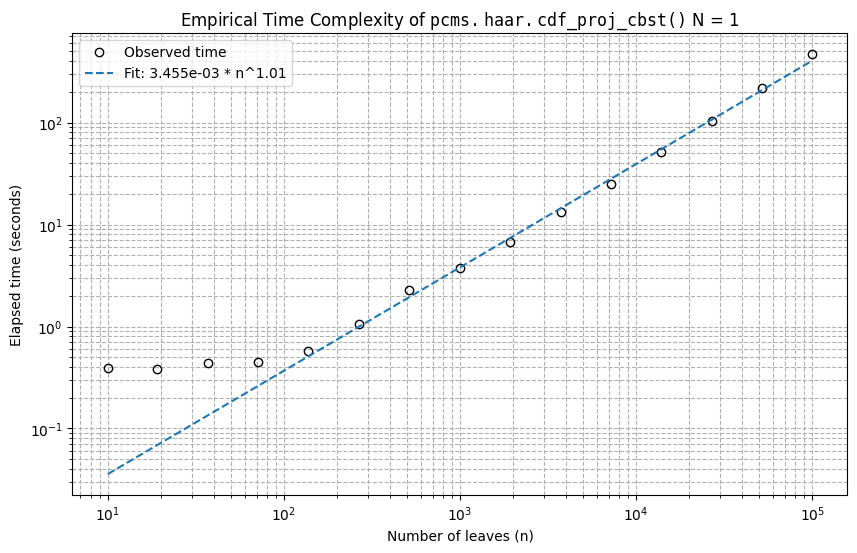

In [ ]:
burn_in = 5

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes1)
log_times = np.log10(times1)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes1**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes1, times1,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes1, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Number of leaves (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

In [20]:
process = psutil.Process()

sizes2 = np.logspace(1, 8, num=15, dtype=int)
times2 = []
memories2 = []
n_leaves = 1000

f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g

for n_points in sizes2:
    y = np.linspace(0, 0.1, n_points)

    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=500)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times2.append(elapsed)
    memories2.append(mem_after - mem_before)  # memory difference in MB

    print(f"n_points = {n_points:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

n_points =      10 | time = 3.96964 sec | memory change = 0.21 MB
n_points =      31 | time = 3.83084 sec | memory change = 0.00 MB
n_points =     100 | time = 3.84262 sec | memory change = 0.00 MB
n_points =     316 | time = 3.79303 sec | memory change = 0.00 MB
n_points =    1000 | time = 4.36598 sec | memory change = -0.01 MB
n_points =    3162 | time = 3.92913 sec | memory change = 0.01 MB
n_points =   10000 | time = 3.94084 sec | memory change = 0.00 MB
n_points =   31622 | time = 3.96067 sec | memory change = -0.01 MB
n_points =  100000 | time = 4.03930 sec | memory change = 11.40 MB
n_points =  316227 | time = 4.07176 sec | memory change = 4.17 MB
n_points = 1000000 | time = 4.11871 sec | memory change = 19.50 MB
n_points = 3162277 | time = 3.72065 sec | memory change = 23.71 MB
n_points = 10000000 | time = 3.77556 sec | memory change = 52.20 MB
n_points = 31622776 | time = 3.84717 sec | memory change = 164.97 MB
n_points = 100000000 | time = 4.30723 sec | memory change = 521.68

Fit: T(n) ≈ 3.91876 * n^0.00 (after burn-in=0)


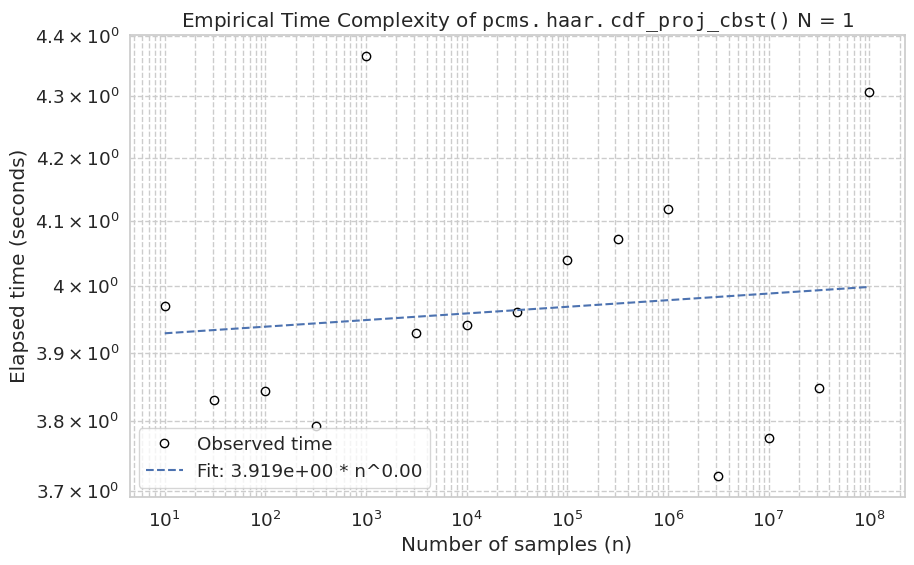

In [47]:
burn_in = 0

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes2)
log_times = np.log10(times2)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes2**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes2, times2,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes2, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Number of samples (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

In [45]:
process = psutil.Process()

sizes3 = np.logspace(0, 3, num=8, dtype=int)
times3 = []
memories3 = []
n_leaves = 1000
y = 0.01

f = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
g = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
func = f - g

for batch_size in sizes3:
    mem_before = process.memory_info().rss / (1024 ** 2)  # in MB
    start = time.time()
    _ = pcms.haar.cdf_proj_cbst(y, func, eps=0.005, delta=0.01, batch_size=batch_size)
    elapsed = time.time() - start
    mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

    times3.append(elapsed)
    memories3.append(mem_after - mem_before)  # memory difference in MB

    print(f"batch_size = {batch_size:7d} | time = {elapsed:.5f} sec | memory change = {mem_after - mem_before:.2f} MB")

batch_size =       1 | time = 35.67350 sec | memory change = 0.00 MB
batch_size =       2 | time = 19.26267 sec | memory change = 0.00 MB
batch_size =       7 | time = 10.23794 sec | memory change = 0.20 MB
batch_size =      19 | time = 7.44545 sec | memory change = -0.01 MB
batch_size =      51 | time = 5.21468 sec | memory change = -0.02 MB
batch_size =     138 | time = 4.30055 sec | memory change = 0.01 MB
batch_size =     372 | time = 3.82171 sec | memory change = 0.01 MB
batch_size =    1000 | time = 3.41441 sec | memory change = 0.00 MB


Fit: T(n) ≈ 23.9613 * n^-0.33 (after burn-in=0)


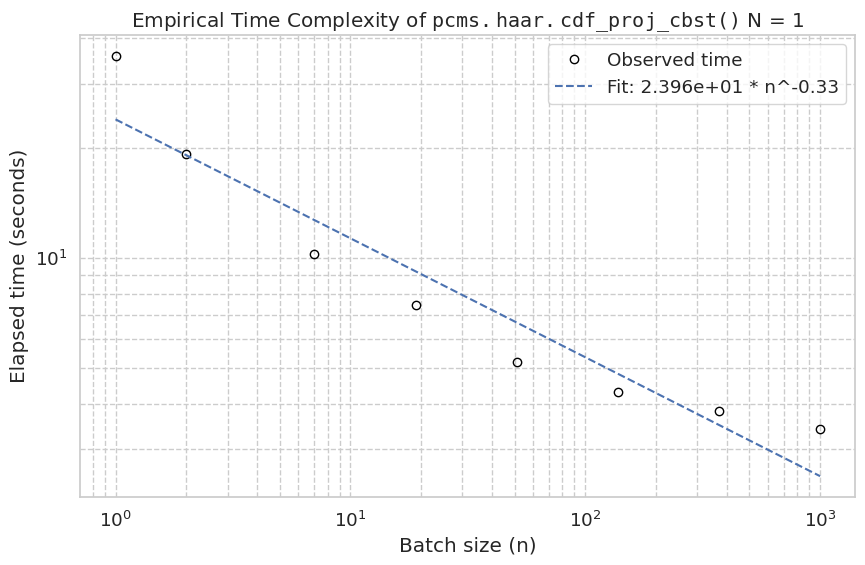

In [46]:
burn_in = 0

# ---- Fit in log–log space ----
log_sizes = np.log10(sizes3)
log_times = np.log10(times3)

slope_time, intercept_time, _, _, _ = linregress(
    log_sizes[burn_in:], log_times[burn_in:]
)
alpha = slope_time
a = 10**intercept_time  # coefficient

print(f"Fit: T(n) ≈ {a:.6g} * n^{alpha:.2f} (after burn-in={burn_in})")

# Predicted times
fit_times = a * sizes3**alpha

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 6))

# Observed times: black hollow circles
ax.loglog(
    sizes3, times3,
    linestyle='',
    marker='o',
    markerfacecolor='none',
    markeredgecolor='black',
    label='Observed time'
)

# Best-fit line
ax.loglog(
    sizes3, fit_times,
    linestyle='--',
    color='C0',
    label=f"Fit: {a:.3e} * n^{alpha:.2f}"
)

ax.set_xlabel("Batch size (n)")
ax.set_ylabel("Elapsed time (seconds)")
ax.set_title(r"Empirical Time Complexity of $\mathtt{pcms.haar.cdf\_proj\_cbst()}$ N = 1")
ax.legend()
ax.grid(True, which="both", ls="--")

plt.show()

#### Evaluate at multiple points

In [15]:
n_points = 1000
ys_cbst = np.linspace(-0.0001, 0.0001, n_points)

In [16]:
cdf_vals_cbst = pcms.haar.cdf_proj_cbst(ys_cbst, func, eps=0.005, delta=0.01)

In [17]:
quantile_levels = [0.5, 0.8, 0.9, 0.95]
quantiles_cbst = np.interp(quantile_levels, cdf_vals_cbst, ys_cbst)
quant50_cbst, quant80_cbst, quant90_cbst, quant95_cbst = quantiles_cbst

In [18]:
print(quant50_cbst, quant80_cbst, quant90_cbst, quant95_cbst)

4.7472013621519845e-06 2.593849323776331e-05 5.0493410076743415e-05 8.121698621698616e-05


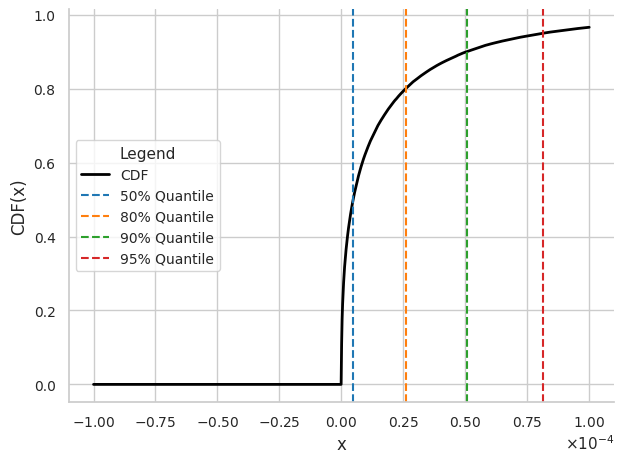

In [19]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax.plot(ys_cbst, cdf_vals_cbst, label='CDF', color='black', linewidth=2)

ax.axvline(quant50_cbst, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_cbst, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_cbst, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_cbst, linestyle='--', color='#d62728', label='95% Quantile')

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

# Scientific notation formatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 4))  # Use scientific notation if exponent < -3 or > 4
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

### Difference of Dirichlets CDF

#### Evaluate at a single point

In [14]:
n_leaves = 1000
tree = pcms.tree.cbst(n_leaves=n_leaves)
y = 0.04
eps = 0.01
delta = 0.01

In [15]:
node = np.random.choice(tree.find_interior_nodes())

In [ ]:
cdf_val_dod = pcms.haar.cdf_proj_dod(y, tree, node=node)

In [17]:
print(cdf_val_dod)

1.0


#### Evaluate at multiple points

In [18]:
n_points = 1000
ys_dod = np.linspace(-0.01, 0.01, n_points)

In [ ]:
cdf_vals_dod = pcms.haar.cdf_proj_dod(ys_dod, tree, node=node)

In [20]:
quantile_levels = [0.5, 0.8, 0.9, 0.95]
quantiles_dod = np.interp(quantile_levels, cdf_vals_dod, ys_dod)
quant50_dod, quant80_dod, quant90_dod, quant95_dod = quantiles_dod

In [21]:
print(quant50_dod, quant80_dod, quant90_dod, quant95_dod)

1.5737386871405864e-06 0.0024869083643030004 0.003909793664632373 0.005174799799799798


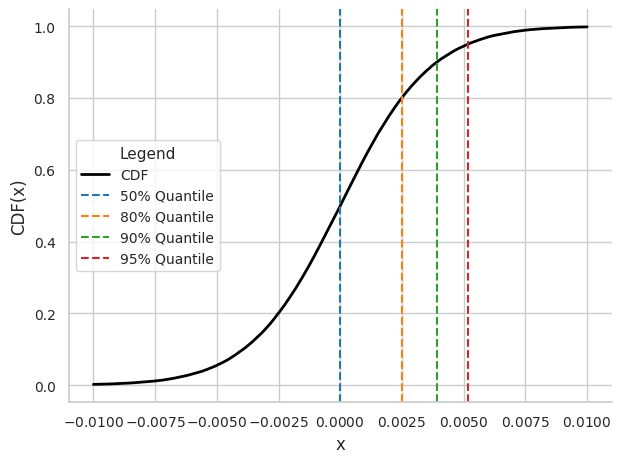

In [22]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

ax.plot(ys_dod, cdf_vals_dod, label='CDF', color='black', linewidth=2)

ax.axvline(quant50_dod, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80_dod, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90_dod, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95_dod, linestyle='--', color='#d62728', label='95% Quantile')

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)

# Scientific notation formatter
formatter = mtick.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 4))  # Use scientific notation if exponent < -3 or > 4
ax.xaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="center left", frameon=True)

plt.tight_layout()
plt.show()

## Part 2: Level of significance of Haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

### Load 97% Greengenes tree

In [4]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

### Load Guerrero Negro dataset

In [5]:
gn_table_filepath = os.path.join(GN_DATA, '454/47908_otu_table.tsv')
table_df = utils.load_gn_seq_id_abundances(gn_table_filepath)

In [6]:
# Convert counts to proportions
cols = table_df.columns[1:]
table_df[cols] = table_df[cols].div(table_df[cols].sum(axis=0), axis=1)

# Append leaf index column
leaf_idxs = seq_id2leaf_idx[table_df['OTU ID']].values
table_df.loc[:, 'Leaf Index'] = leaf_idxs
table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [7]:
print(table_df)

       OTU ID  1200.GN01P  1200.GN01P.o  1200.GN02P  1200.GN02P.o  1200.GN03P  \
0     2773512    0.000000           0.0    0.000000      0.000602    0.000000   
1     4361967    0.000000           0.0    0.000000      0.000602    0.000000   
2     3675511    0.001170           0.0    0.001155      0.000000    0.000696   
3     2877492    0.000000           0.0    0.000578      0.000000    0.001392   
4     4481520    0.000000           0.0    0.000000      0.000000    0.008351   
...       ...         ...           ...         ...           ...         ...   
1700  4331263    0.000000           0.0    0.000000      0.000000    0.000000   
1701   252805    0.000585           0.0    0.001733      0.003008    0.000696   
1702  4453795    0.000000           0.0    0.000000      0.000000    0.001392   
1703  1549742    0.000000           0.0    0.000000      0.000000    0.000000   
1704  1636411    0.000000           0.0    0.000000      0.000000    0.000000   

      1200.GN03P.o  1200.GN

### Compute Haar-like coordinates

In [8]:
Q, S = pcms.haar.sparsify(tree)

In [9]:
diff_s = table_df['1200.GN09P.o'] - table_df['1200.GN01P.o']

mask = diff_s != 0

values = diff_s[mask].values
indices = table_df['Leaf Index'][mask].values
indptr = [0, len(values)]

diff = csc_matrix((values, indices, indptr), shape=(n_leaves,1))

In [10]:
coords = (Q.T @ diff).tocsc()

In [11]:
coords.indptr

array([   0, 4271], dtype=int32)

In [12]:
values = coords.data**2 * S.diagonal()[coords.indices]
indices = coords.indices[values != 0]
values = values[values != 0]
indptr = np.array([0, values.size], dtype=np.int32)
dh_coords = csc_matrix((values, indices, indptr))

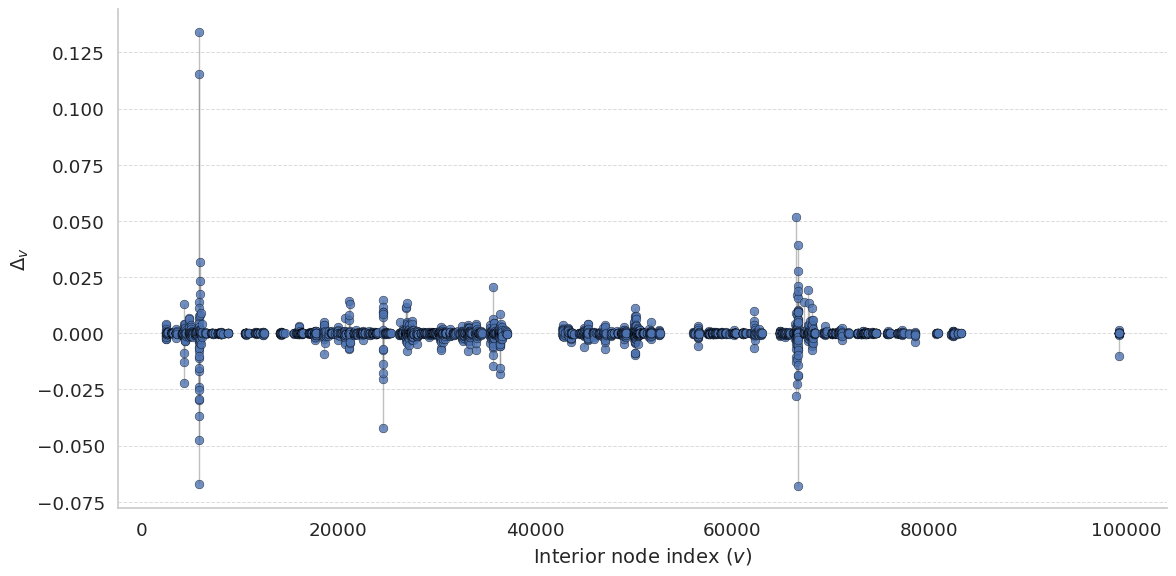

In [13]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points colored by value with better aesthetics
scatter = ax.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Draw vertical lines behind scatter points
ax.vlines(
    x=coords.indices,
    ymin=0,
    ymax=coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Improve axes labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

# Add a grid on y-axis only for clarity
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()

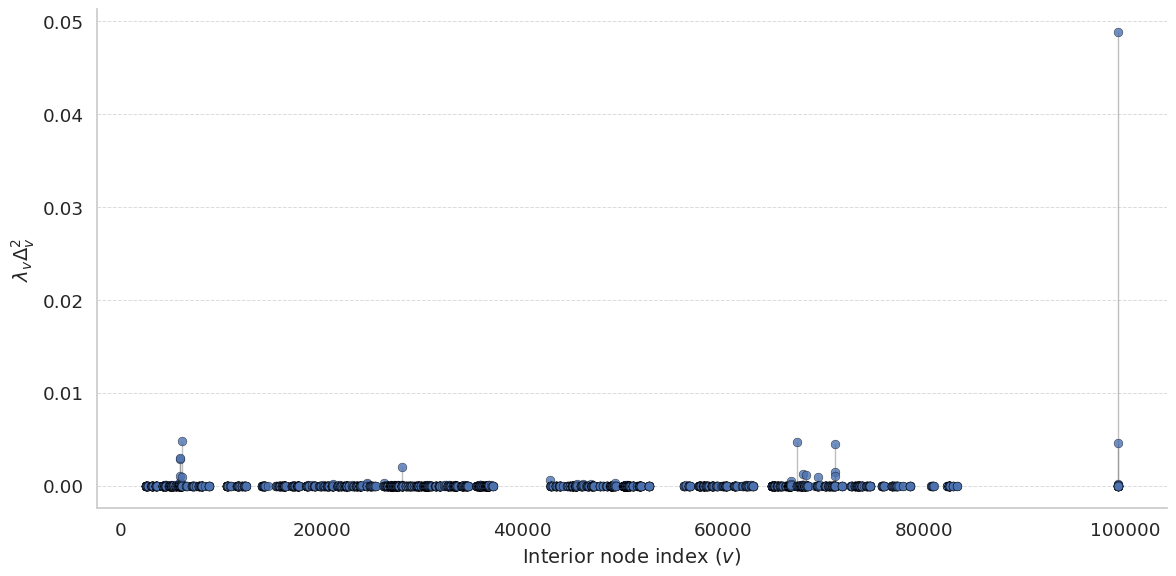

In [14]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter points with subtle edge for clarity
scatter = ax.scatter(
    dh_coords.indices[:-1],
    dh_coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Vertical lines behind scatter points
ax.vlines(
    x=dh_coords.indices,
    ymin=0,
    ymax=dh_coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)

# Labels
ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

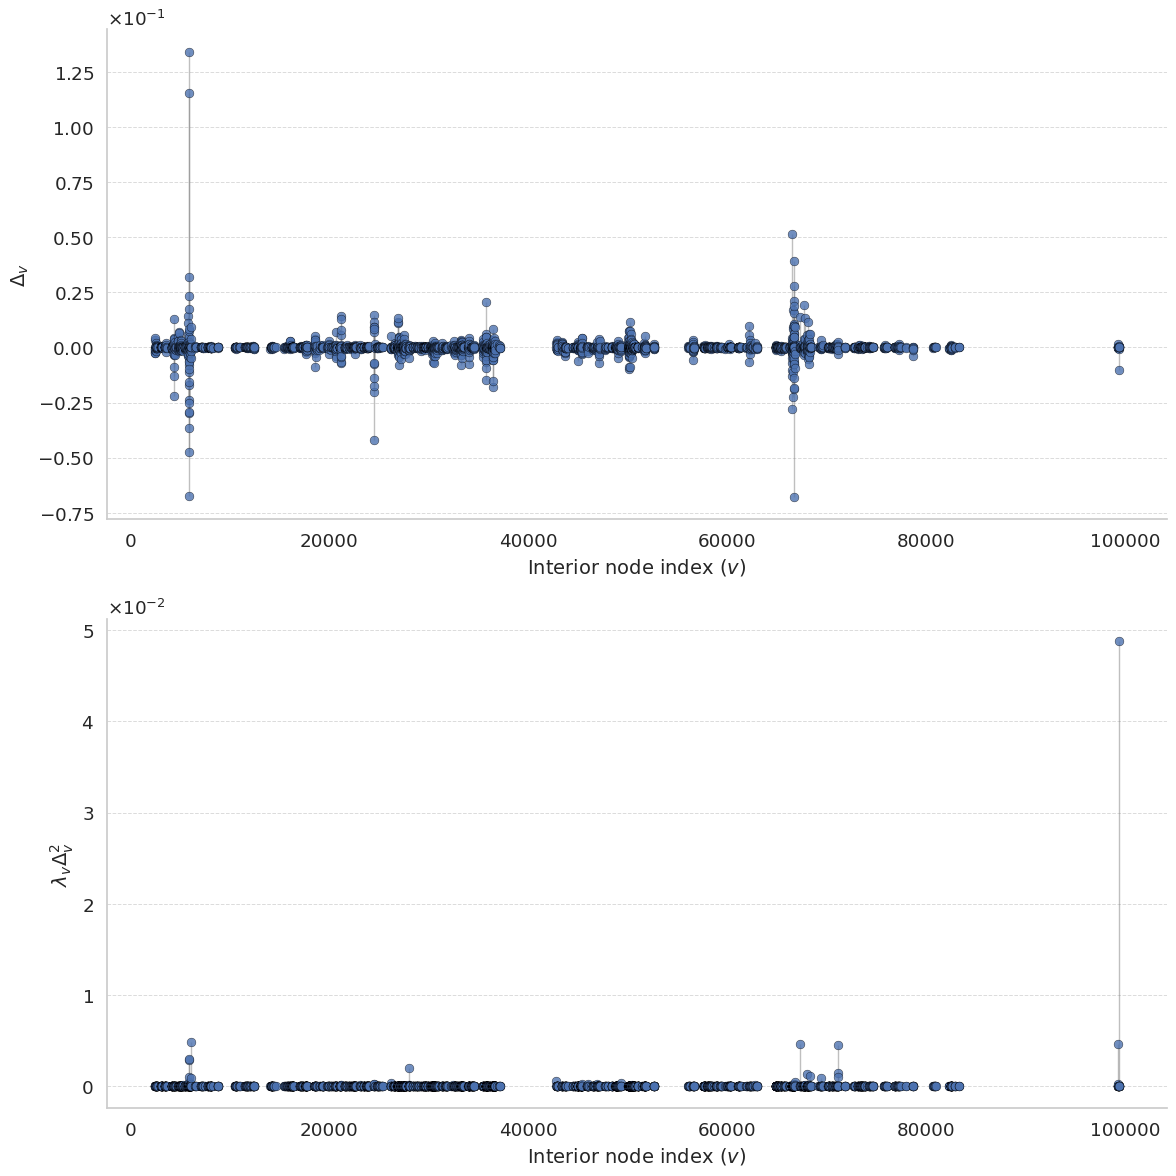

In [15]:
sns.set(style="whitegrid", font_scale=1.2)

# Create figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=False)

# --- Plot 1: coords plot ---
scatter1 = ax1.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
ax1.vlines(
    x=coords.indices,
    ymin=0,
    ymax=coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax1.set_xlabel('Interior node index ($v$)', fontsize=14)
ax1.set_ylabel(r'$\Delta_v$', fontsize=14)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax1.xaxis.grid(False)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax1)

# --- Plot 2: dh_coords plot ---
scatter2 = ax2.scatter(
    dh_coords.indices[:-1],
    dh_coords.data[:-1],
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)
ax2.vlines(
    x=dh_coords.indices,
    ymin=0,
    ymax=dh_coords.data,
    colors='gray',
    alpha=0.5,
    linewidth=1,
    zorder=1
)
ax2.set_xlabel('Interior node index ($v$)', fontsize=14)
ax2.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax2.xaxis.grid(False)
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

### Compute level of significance

#### Edge length distribution

In [16]:
edge_lengths = tree.get_edge_length()
subtree_sizes = tree.get_subtree_size()

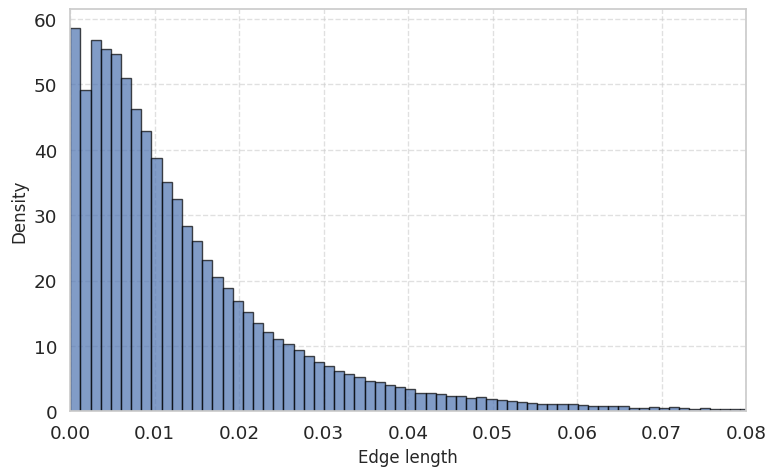

In [17]:
n_bins = int(np.sqrt(tree.n_nodes))
pdf_values, bin_edges = np.histogram(edge_lengths, bins=n_bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)

output_path = "../data/gg_97_otus_edge_length_distribution.csv"
np.savetxt(
    output_path,
    np.column_stack([bin_centers, pdf_values]),
    delimiter=",",
    header="bin_center,pdf_value",
    comments=''
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(bin_centers, pdf_values, width=bin_widths, color='C0', edgecolor='black', alpha=0.7, label='PDF')
ax.set_xlim(0, 0.08)
ax.set_ylim(bottom=0)
ax.set_xlabel('Edge length', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.grid(visible=True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()

In [18]:
indxs = np.argsort(subtree_sizes)

In [ ]:
start_time = time.time()
T_obs, p, Ts = utils.perm_test_maxsplit_ks(edge_lengths[indxs], eps=0.01, delta=0.01)
print("Elapsed time: ", start_time)

In [ ]:
print(f"T_obs: {T_obs}, p: {p}")

In [25]:
avg_child_edge_lengths = np.ndarray(edge_lengths.shape)
for i in range(edge_lengths.size):
    if tree.get_child(i) == -1:
        avg_child_edge_lengths[i] = 0
        continue
    children = tree.find_children(i)
    child_lengths = [edge_lengths[c] for c in children]
    avg_child_edge_lengths[i] = np.mean(child_lengths)

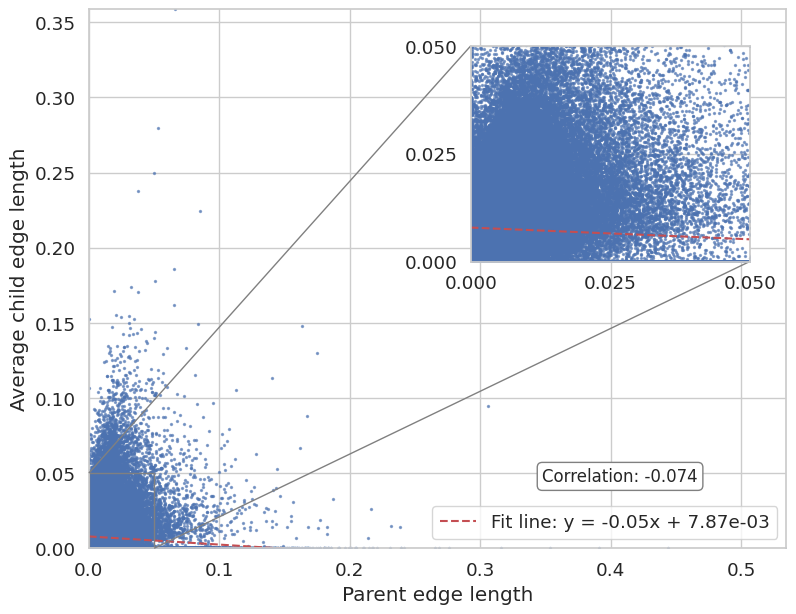

In [27]:
fig, ax = plt.subplots(figsize=(9,7))

# Compute correlation coefficient
corr = np.corrcoef(avg_child_edge_lengths, edge_lengths)[0, 1]

# Linear regression parameters (y = m*x + b)
m, b = np.polyfit(edge_lengths, avg_child_edge_lengths, 1)

# Scatter plot full range
ax.scatter(edge_lengths, avg_child_edge_lengths, s=2, alpha=0.6)
ax.set_xlabel("Parent edge length")
ax.set_ylabel("Average child edge length")

# Plot the best fit line on full range
x_vals = np.array([edge_lengths.min(), edge_lengths.max()])
y_vals = m * x_vals + b
ax.plot(x_vals, y_vals, 'r--', label=f"Fit line: y = {m:.2f}x + {b:.2e}")

ax.set_xlim(edge_lengths.min(), edge_lengths.max())
ax.set_ylim(avg_child_edge_lengths.min(), avg_child_edge_lengths.max())

# Add correlation coefficient text
ax.text(0.65, 0.15, f"Correlation: {corr:.3f}", transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"))

# Create inset axes for zoomed plot
axins = inset_axes(ax, width="40%", height="40%", loc='upper right', borderpad=2)

# Scatter zoomed in
axins.scatter(edge_lengths, avg_child_edge_lengths, s=2, alpha=0.6)

# Zoomed best fit line (same slope/intercept)
x_zoom = np.array([0, 0.05])
y_zoom = m * x_zoom + b
axins.plot(x_zoom, y_zoom, 'r--')

axins.set_xlim(0, 0.05)
axins.set_ylim(0, 0.05)
axins.set_xticks([0, 0.025, 0.05])
axins.set_yticks([0, 0.025, 0.05])

# Draw rectangle on main plot showing zoom region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.legend(loc='lower right')
plt.show()

#### Random topology CDF

In [ ]:
total = 0
for node in tree.find_interior_nodes()[dh_coords.indices]:
    n = tree.get_subtree_size(node)
    total += 0.00345485 * n ** 1.01

estimated_time = timedelta(seconds=total)
print("Estimated time:", estimated_time)

Estimated time: 3:29:06.011108


In [24]:
subtree_sizes = tree.get_subtree_size()
start_indices = tree.find_subtree_start_indices()
j_idx = tree.find_interior_nodes()[dh_coords.indices][0]
size = subtree_sizes[j_idx]
start = start_indices[j_idx] 
np.squeeze(dh_coords[start:start+size].toarray())

array([1.75436999e-08, 5.69113328e-08])

In [ ]:
start_time = time.time()

subtree_sizes = tree.get_subtree_size()
start_indices = tree.find_subtree_start_indices()

pvals_cbst = np.zeros(dh_coords.shape)
for i_idx, j_idx in enumerate(tree.find_interior_nodes()[dh_coords.indices]):
    size = subtree_sizes[j_idx]
    start = start_indices[j_idx] 
    func = np.squeeze(dh_coords[start:start+size].toarray())
    cdf_val = pcms.haar.cdf_proj_cbst(
        dh_coords.data[i_idx], 
        f=func,
        eps=0.01,
        delta=0.01,
        batch_size=1000
    )
    pvals_cbst[i_idx] = 1 - cdf_val

print("Elapsed time: ", time.time() - start_time)

In [ ]:
alpha = 0.05
do_reject_cbst = pvals_cbst < alpha

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_cbst to binary colors: True → red, False → blue
colors = np.where(do_reject_cbst[:-1], 'red', 'blue')

# Scatter plot with edge color for clarity
scatter = ax.scatter(
    dh_coords.indices[:-1],
    dh_coords[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-14, 1e-2])

# Custom legend with edge color to match scatter
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Labels
ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Clean up plot spines
sns.despine()

plt.tight_layout()
plt.show()

In [ ]:
N = 10

nodes = tree.find_interior_nodes()[coords.indices]
subtree_sizes = tree.get_subtree_size()[nodes]
subtree_starts = tree.find_subtree_start_indices()[nodes]

sort_idx = np.argsort(dh_coords[:-1])[::-1]
ordered_coords = coords.data[sort_idx]
ordered_indices = coords.indices[sort_idx]
ordered_dh_coords = dh_coords[sort_idx]
ordered_dh_coords.indices = dh_coords.indices[sort_idx]
ordered_subtree_sizes = subtree_sizes[sort_idx]
ordered_subtree_starts = subtree_starts[sort_idx]

In [57]:
total = 0
for idx in range(N):
    n = ordered_subtree_sizes[idx]
    total += 0.00345485 * n ** 1.01

estimated_time = timedelta(seconds=total)
print("Estimated time:", estimated_time)

Estimated time: 0:12:12.872363


In [ ]:
start_time = time.time()

print(f"{'Index':>10} {'Subtree Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 48)

for idx in range(N):
    start = ordered_subtree_starts[idx]
    width = ordered_subtree_sizes[idx]
    func = diff[start:start + width].toarray().reshape(-1)
    cdf_val = pcms.haar.cdf_proj_cbst(
        ordered_dh_coords[idx], 
        f=func,
        eps=0.005,
        delta=0.01,
        batch_size=1000
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    print(f"{ordered_dh_coords.indices[idx]+1:>10} {ordered_subtree_sizes[idx]:>14} {ordered_dh_coords[idx]:>10.4f} {pval:>10.3e}")

print("\nElapsed time: ", time.time() - start_time)

     Index   Subtree Size  Component    P-Value
------------------------------------------------
     99311          95297     0.0488  0.000e+00
      6079           1792     0.0048  1.285e-02
     67317            835     0.0047  3.850e-03
     99307          50035     0.0046  3.775e-05
     71160          14472     0.0045  5.662e-05
      5923            600     0.0030  9.913e-02
      5921            240     0.0029  2.215e-01
     27998          20765     0.0020  5.662e-05
     71159           4899     0.0014  4.228e-03
     67959           1477     0.0013  2.520e-02

Elapsed time:  717.2858076095581


#### Difference of Dirichlet CDF

In [ ]:
start = time.time()

pvals_dod = np.zeros(coords.data.shape)
for i_idx, j_idx in enumerate(tree.find_interior_nodes()[coords.indices]):
    children = tree.find_children(j_idx)
    if children.size == 1:
        pvals_dod[i_idx] = 1.0
    else:
        cdf_val = pcms.haar.cdf_proj_dod(
            coords.data[i_idx], 
            tree=tree,
            node=j_idx,
            eps=0.01,
            delta=0.01
        )
        pvals_dod[i_idx] = 2 * min(cdf_val, 1 - cdf_val)

print("Elapsed time: ", time.time() - start)

Elapsed time:  19.381924629211426


In [ ]:
alpha = 0.05
do_reject_dod = pvals_dod < alpha

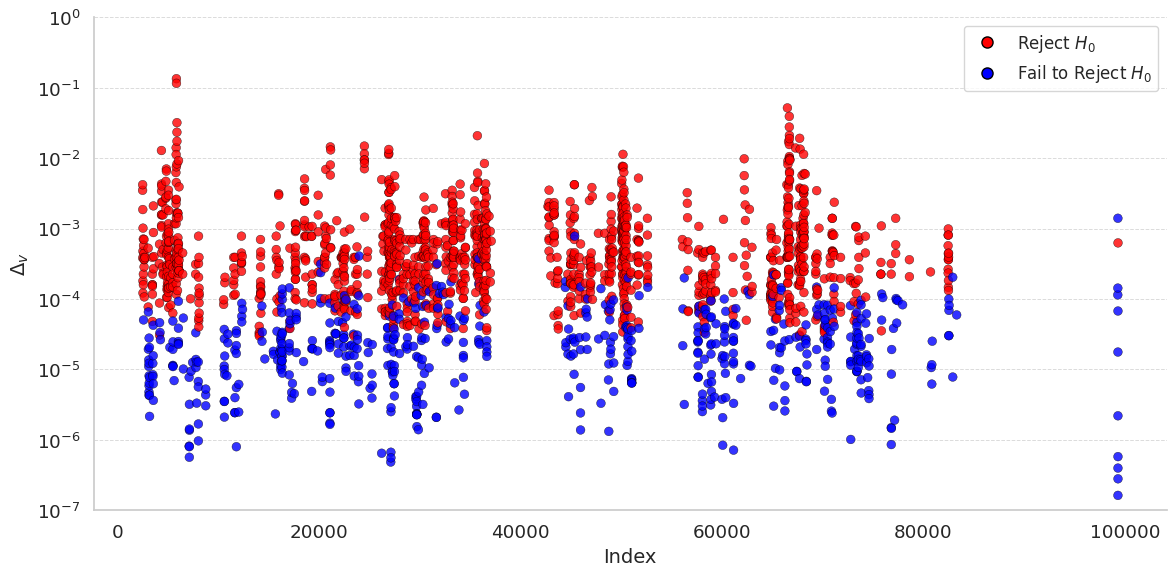

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter with edge and higher zorder
scatter = ax.scatter(
    coords.indices[:-1],
    coords.data[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Use log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-7, 1])

# Custom legend with clearer labels and markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Axis labels
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel(r'$\Delta_{v}$', fontsize=14)

# Add y-axis grid only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Remove clutter
sns.despine()

plt.tight_layout()
plt.show()

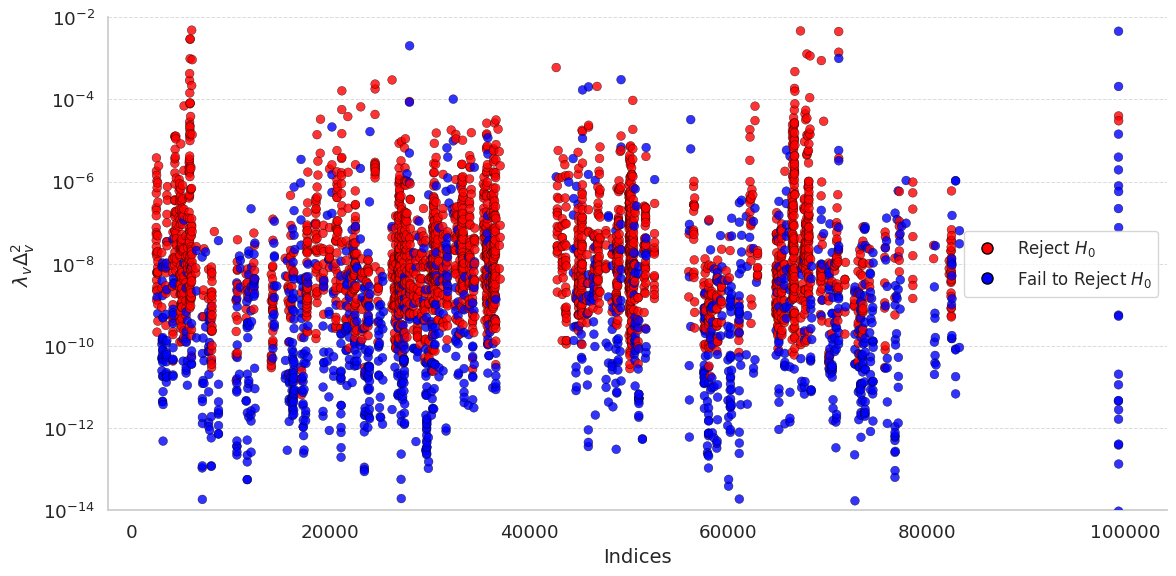

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

# Map do_reject_dod to binary colors: True → red, False → blue
colors = np.where(do_reject_dod[:-1], 'red', 'blue')

# Scatter plot with edge color for clarity
scatter = ax.scatter(
    dh_coords.indices[:-1],
    dh_coords[:-1],
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

# Log scale for y-axis
ax.set_yscale('log')
ax.set_ylim([1e-14, 1e-2])

# Custom legend with edge color to match scatter
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Reject $H_0$', markerfacecolor='red',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Fail to Reject $H_0$', markerfacecolor='blue',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

# Labels
ax.set_xlabel('Indices', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

# Grid: y-axis only
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Clean up plot spines
sns.despine()

plt.tight_layout()
plt.show()

In [ ]:
N = 10

nodes = tree.find_interior_nodes()[coords.indices]
subtree_sizes = tree.get_subtree_size()[nodes]
subtree_starts = tree.find_subtree_start_indices()[nodes]

sort_idx = np.argsort(dh_coords[:-1])[::-1]
ordered_coords = coords.data[sort_idx]
ordered_indices = coords.indices[sort_idx]
ordered_dh_coords = dh_coords[sort_idx]
ordered_dh_coords.indices = dh_coords.indices[sort_idx]
ordered_subtree_sizes = subtree_sizes[sort_idx]
ordered_subtree_starts = subtree_starts[sort_idx]
ordered_nodes = nodes[sort_idx]

print(f"{'Index':>10} {'Subtree Size':>14} {'Component':>10} {'P-Value':>10}")
print("-" * 50)

for idx in range(N):
    cdf_val = pcms.haar.cdf_proj_dod(
        ordered_coords[idx], 
        tree=tree,
        node=ordered_nodes[idx],
        eps=0.0005,
        delta=0.0001
    )
    pval = 2 * min(cdf_val, 1 - cdf_val)
    print(f"{ordered_dh_coords.indices[idx]+1:>10} {ordered_subtree_sizes[idx]:>14} {ordered_dh_coords[idx]:>10.4f} {pval:>10.3e}")

     Index   Subtree Size  Component    P-Value
--------------------------------------------------
     99311          95297     0.0488  0.000e+00
      6079           1792     0.0048  0.000e+00
     67317            835     0.0047  0.000e+00
     99307          50035     0.0046  3.759e-01
     71160          14472     0.0045  3.786e-04
      5923            600     0.0030  0.000e+00
      5921            240     0.0029  0.000e+00
     27998          20765     0.0020  1.408e-01
     71159           4899     0.0014  5.049e-07
     67959           1477     0.0013  0.000e+00
